In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


⏳ Loading dataset...


/tmp/ipython-input-2736557534.py:16: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, encoding='latin1') # Added encoding parameter


✅ Data Prepared: 260000 rows
Training Model...
0:	learn: 129.8176951	total: 228ms	remaining: 3m 48s
100:	learn: 119.5275697	total: 10.1s	remaining: 1m 29s
200:	learn: 115.0931022	total: 18.7s	remaining: 1m 14s
300:	learn: 110.6288979	total: 28.2s	remaining: 1m 5s
400:	learn: 107.5053598	total: 36.5s	remaining: 54.5s
500:	learn: 105.1181253	total: 46s	remaining: 45.8s
600:	learn: 103.5193950	total: 55.9s	remaining: 37.1s
700:	learn: 101.9536248	total: 1m 6s	remaining: 28.3s
800:	learn: 100.8670164	total: 1m 16s	remaining: 18.9s
900:	learn: 99.9085733	total: 1m 28s	remaining: 9.72s
999:	learn: 98.9014674	total: 1m 37s	remaining: 0us

 Model Performance:
   R² Score: 0.4688
   MAE: Rs 77.43
✅ Saved 'residual_plot.png' and 'error_histogram.png'


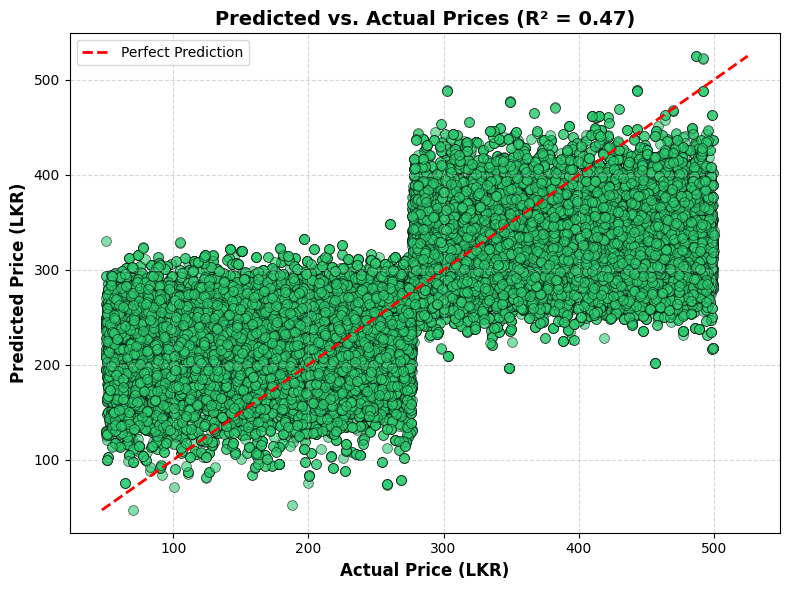

💾 Model saved to 'market_price_model.cbm'


In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
FILE_PATH = "Vegetables_fruit_prices.csv"
MODEL_FILE = "market_price_model.cbm"

def load_and_prep_data(filepath):
    print("⏳ Loading dataset...")
    df = pd.read_csv(filepath, encoding='latin1') # Added encoding parameter

    # 1. Clean Column Names (Handling special characters)
    temp_col = [c for c in df.columns if "Temp" in c][0]

    df = df.rename(columns={
        temp_col: 'Temperature',
        'Rainfall (mm)': 'Rainfall',
        'Humidity (%)': 'Humidity',
        'fruit_Commodity': 'Fruit_Item',
        'fruit_Price per Unit (LKR/kg)': 'Fruit_Price',
        'vegitable_Commodity': 'Veg_Item',
        'vegitable_Price per Unit (LKR/kg)': 'Veg_Price'
    })

    # 2. Date Features
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month_Num'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    # 3. Combine Fruits and Vegs into one list
    # I need a single 'Item' column and a single 'Price' column
    common_cols = ['Date', 'Month_Num', 'Year', 'Region', 'Temperature', 'Rainfall', 'Humidity']

    # Process Fruits
    df_fruits = df[common_cols + ['Fruit_Item', 'Fruit_Price']].rename(
        columns={'Fruit_Item': 'Item', 'Fruit_Price': 'Price'}
    )
    df_fruits['Category'] = 'Fruit'

    # Process Vegetables
    df_veg = df[common_cols + ['Veg_Item', 'Veg_Price']].rename(
        columns={'Veg_Item': 'Item', 'Veg_Price': 'Price'}
    )
    df_veg['Category'] = 'Vegetable'

    # Combine
    final_df = pd.concat([df_fruits, df_veg], ignore_index=True)

    # Remove rows with 0 or negative prices
    final_df = final_df[final_df['Price'] > 0].dropna()

    print(f"✅ Data Prepared: {len(final_df)} rows")
    return final_df

def plot_predicted_vs_actual(y_test, preds):

    # Calculate R-squared for the plot title
    r2 = r2_score(y_test, preds)

    # Create the figure
    plt.figure(figsize=(8, 6))

    # 1. Create the Scatter Plot
    sns.scatterplot(x=y_test, y=preds, alpha=0.6, color="#2ecc71", edgecolor="k", s=50)

    # 2. Add the "Perfect Prediction" Diagonal Line (Reference Line)
    min_val = min(min(y_test), min(preds))
    max_val = max(max(y_test), max(preds))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

    # 3. Add Labels and Title
    plt.xlabel("Actual Price (LKR)", fontsize=12, fontweight='bold')
    plt.ylabel("Predicted Price (LKR)", fontsize=12, fontweight='bold')
    plt.title(f"Predicted vs. Actual Prices (R² = {r2:.2f})", fontsize=14, fontweight='bold')

    # 4. Add Grid and Legend
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # 5. Show/Save the Plot
    plt.tight_layout()
    plt.savefig("predicted_vs_actual_plot.png", dpi=300)
    plt.show()

def plot_regression_analysis(y_test, preds):

    residuals = y_test - preds

    # --- Plot 1: Residual Plot (Homoscedasticity Check) ---
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=preds, y=residuals, alpha=0.6, color='#e74c3c', edgecolor='k')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
    plt.xlabel("Predicted Price (LKR)", fontsize=12)
    plt.ylabel("Residuals (Error)", fontsize=12)
    plt.title("Residual Plot: Where is the model making errors?", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("residual_plot.png", dpi=300)
    plt.close()

    # --- Plot 2: Error Histogram (Bias Check) ---
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color='#3498db', bins=30)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=2)
    plt.xlabel("Prediction Error (LKR)", fontsize=12)
    plt.title("Error Distribution (Zero is ideal)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("error_histogram.png", dpi=300)
    plt.close()

    print("✅ Saved 'residual_plot.png' and 'error_histogram.png'")

def train_model():
    df = load_and_prep_data(FILE_PATH)

    # CatBoost handles categorical features (Item, Region) automatically.
    features = ['Region', 'Item', 'Category', 'Month_Num', 'Temperature', 'Rainfall', 'Humidity']
    target = 'Price'

    X = df[features]
    y = df[target]

    # Identify Categorical Columns indices
    cat_features_indices = [X.columns.get_loc(c) for c in ['Region', 'Item', 'Category']]

    # Split
    print("Training Model...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize CatBoost Regressor
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        cat_features=cat_features_indices,
        verbose=100
    )

    model.fit(X_train, y_train)

    # Evaluate
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)

    print(f"\n Model Performance:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MAE: Rs {mae:.2f}")

    plot_regression_analysis(y_test, preds)

    plot_predicted_vs_actual(y_test, preds)

    # Save
    model.save_model(MODEL_FILE)
    print(f"💾 Model saved to '{MODEL_FILE}'")

if __name__ == "__main__":
    train_model()